# Introduction to Image Processing

Lecture 1 - Jean-Christophe Taveau
2024/02/02

## 1. Introduction

### 1.1. How to display an image

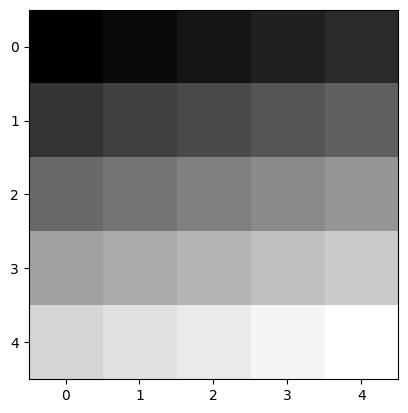

In [1]:
import numpy as np
import matplotlib.pyplot as plt

img = np.arange(25).reshape(5,5)
plt.imshow(img,cmap='gray')


In [2]:
print(img)

[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]
 [20 21 22 23 24]]


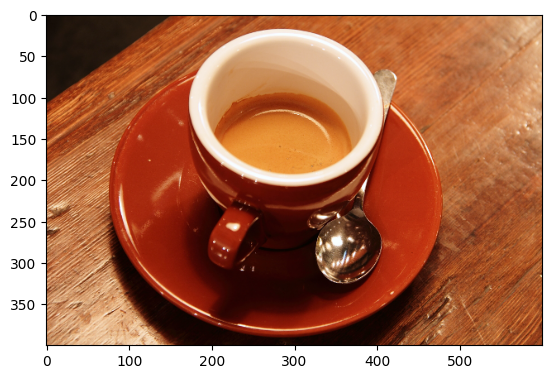

In [3]:
import skimage as ski

cup = ski.data.coffee()
plt.imshow(cup)

### 1.2. How to get the main image parameters (size, data type, number of axes, etc.)

In [4]:
cup.ndim

3

In [5]:
cup.shape

(400, 600, 3)

## 2. Geometrical Transforms
- Translations
- Rotation
- Scaling

![](./assets/Fundamentals-IP_session_1-22.png)

### 2.1. Translating an image in regular Python

In regular Python, we are using two nested loops to scan all the pixels in the image.

(400, 600, 3)
(400, 600, 3)


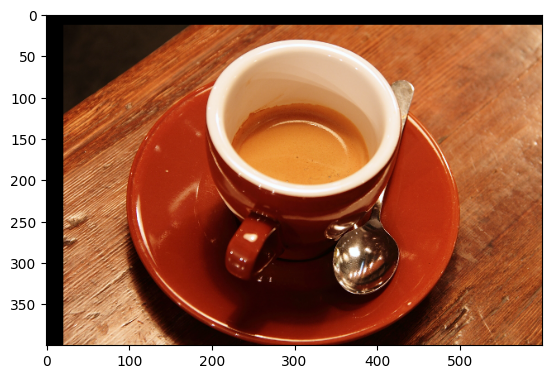

In [6]:
tx = 20.2
ty = 12.9
out = np.zeros(cup.size).reshape(cup.shape)
print(out.shape)
for y in range(out.shape[0]):
  for x in range(out.shape[1]):
    orgx = x - tx
    orgy = y - ty
    if orgx >= 0 and orgy >= 0 and orgx < cup.shape[1] and orgy < cup.shape[0]:
      out[y,x] = cup[int(orgy),int(orgx),:]

print(out.shape)
plt.imshow(out / 255)


### 2.2. Translating the same image with `skimage`

Search in the documentation of skimage [https://scikit-image.org/](https://scikit-image.org/).

In [ ]:
# TODO
tx = 20.2
ty = 12.9
cup_fast = ski.data.coffee()



### 2.3. Transforming an image - Algorithm and Interpolation schemes 

When you apply a geometrical transform to your image. You have to know which values you set in the resulting output image (see slide). 

![](./assets/Fundamentals-IP_session_1-24.png)

The algorithm written in pseudo-code is something like that:

```python
for each pixel in output_image:
    # We compute the x,y coordinates of the INPUT image by applying the INVERSE transform
    x,y = calc_coordinates_from_transform(tf)
    pixel = get_pixel_value(input_image,x,y)
```

The tricky part of this code is the function `get_pixel_values(..)`because the (x,y) are floating-point numbers and there is no such pixel in the input image. Thus, you have to set a strategy for defining the output pixel values.

#### 2.3.2. For example, if you apply a shift of (1.2,23.4), 

The pixel in the output image of coordinates (10,40) will correspond to a pixel in the **input** image of coordinates (8.8, 16.6). Obviously, such a pixel with floating-point coordinates doesn't exist. We have to make an approximation... and this is what is done by the interpolation schemes.

### 2.4.  Understanding the interpolation schemes

- Nearest neighbor
- Bilinear Interpolation
- Bicubic Interpolation (not described, here)

#### Nearest Neighbor

In this scheme, you are just rounding your floating-point coordinates to integer coordinates. In our example, the xy-coordinates become (9,17). Thus, the pixel (10,40) of the output image = pixel(9,17) of the input image.

In this scheme, the output image can appear _jagged_.

#### Bilinear Interpolation

In this scheme, we are taking into account of the four neighbors in the input image (see Fig.). 

In our example, we select the four pixels of XY-coordinates: (8,16), (8,17), (9,16), and (9,17). Then, we are linearly interpolating the final pixel values from these four neighbors.

![](./assets/bilinear_wikipedia.png)

Here is an example from Wikipedia with all the formulas... The question is which pixel value will be set to the pixel (14.(,20.2) knowing the pixel values of the four neighbors.

![](./assets/bilin3.png)

$$I_{20,14.5} ={\frac {15-14.5}{15-14}}\cdot 91+{\frac {14.5-14}{15-14}}\cdot 210=150.5,$$

$$\\I_{21,14.5} ={\frac {15-14.5}{15-14}}\cdot 162+{\frac {14.5-14}{15-14}}\cdot 95=128.5$$

$$I_{20.2,14.5}={\frac {21-20.2}{21-20}}\cdot 150.5+{\frac {20.2-20}{21-20}}\cdot 128.5=146.1.$$



### 2.5. Cumulating Geometrical Transforms

If you apply many geometrical transforms successively on an image. You'll get a blurred image as shown in the example below with the `cup of coffee`.

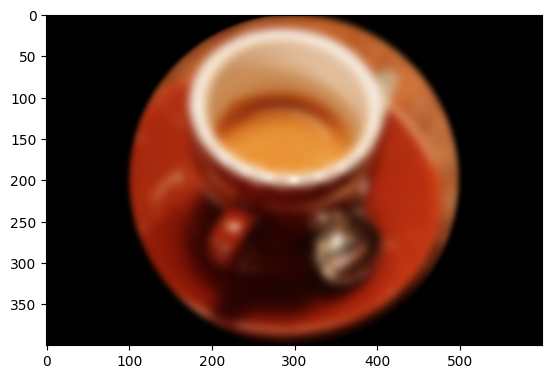

In [8]:
# Successively rotating the cup image with 180 rotations of 2°.
rotated = cup
angle = 360 / 180
for i in range(180):
  rotated = ski.transform.rotate(rotated, angle, resize=False)

# See the final image
plt.imshow(rotated)

###  2.7. Best practices with geometrical transforms

Every 2D geometrical transforms can be described by a 2D 3x3 matrix (see slice).

![](./assets/2D_affine_transformation_matrix.png)

> **Source**: Wikipedia

Thus, the best way to combine several transforms is to multiply the matrices and to apply **ONLY ONCE** the resulting matrix.

Here is an example of code combining three transforms:

- a scale
- a rotation
- a translation 

[[  0.35355339  -0.35355339 100.        ]
 [  0.35355339   0.35355339  50.        ]
 [  0.           0.           1.        ]]


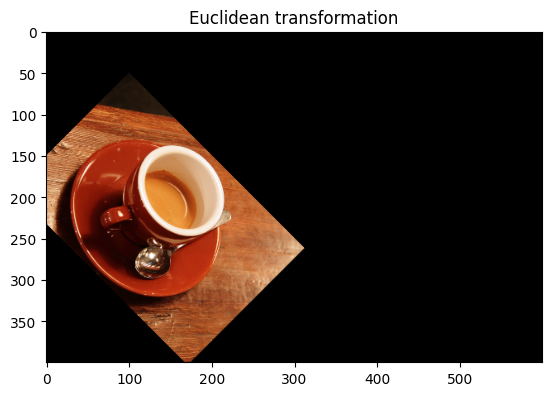

In [12]:
# Create a matrix combining a scale, a rotation and a translation in a SimilarityTransform
tform = ski.transform.SimilarityTransform(
    scale=0.5,
    rotation=np.pi/4,
    translation=(100, 50))

# Print the resulting 2D matrix
print(tform.params)

# Apply the resulting transform with `warp(..)`
img = ski.img_as_float(cup)
tf_img = ski.transform.warp(img, tform.inverse)

# Display the result
fig, ax = plt.subplots()
ax.imshow(tf_img)
_ = ax.set_title('Euclidean transformation')

#### Combining the 180 rotations of 2°

We retry with the cup succesively rotated by 2°.

In this case, we use a new matrix object `EuclideanTransform`.
To get a rotation around the image center, we need to apply a first shift, then all the rotations and finally, the shift inverse.

> **Note**: To see the effects of the shifts, remove them in the next script

<EuclideanTransform(matrix=
    [[   1.,   -0., -300.],
     [   0.,    1., -200.],
     [   0.,    0.,    1.]])>
[[ 1.00000000e+00  1.01708908e-15 -2.27373675e-12]
 [-6.30919087e-16  1.00000000e+00 -1.10844667e-12]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


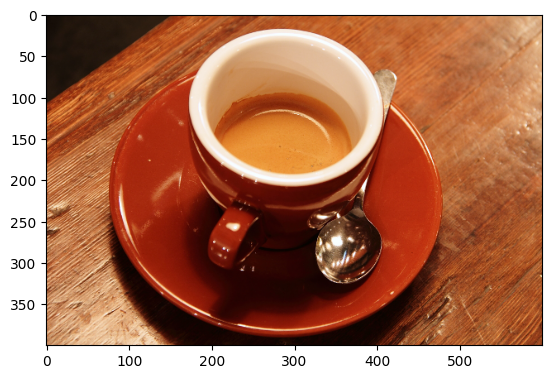

In [13]:
angle = 2.0 # 360 / 180.0
shift = ski.transform.EuclideanTransform(translation=-np.array((cup.shape[1]/2.0,cup.shape[0]/ 2.0)) )
rot= ski.transform.EuclideanTransform(rotation= np.deg2rad(angle))
print(shift)
# Compose transforms by multiplying their matrices

rots = np.identity(3)
for i in range(180):
  rots = rots @ rot # np.matmul(rots,rot)

matrix =  np.linalg.inv(shift.params) @ rots @ shift.params
print(matrix)
# Show...
tform = ski.transform.EuclideanTransform(matrix)
tf_img = ski.transform.warp(img, tform.inverse)

plt.imshow(tf_img)

# End of session 1